# Molecular Dynamics of Docked Structures


You'll need...

```bash
conda install -c conda-forge pdbfixer openmm
```

In [1]:
## Load Libraries
from openmm.app import *
from openmm import *
from openmm.unit import *
from openmm.app import PDBFile
from pdbfixer import PDBFixer

from sys import stdout
import os


In [2]:
input_pbd_file = '../HADDOCK Output Structures/6m0j/6M0J_ACE2_BA286.pdb'
output_pdb_file = input_pbd_file.replace('../HADDOCK Output Structures/', './').replace('.pdb', '_clean.pdb')

print('Cleaning up PDB file...')
print(f'\tInput PDB File: {input_pbd_file}')

## Make folders for output file
output_folder = os.path.dirname(output_pdb_file)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)



Cleaning up PDB file...
	Input PDB File: ../HADDOCK Output Structures/6m0j/6M0J_ACE2_BA286.pdb
	Output PDB File: ./6m0j/6M0J_ACE2_BA286_clean.pdb


In [4]:

print('Fixing PDB file...')

fixer = PDBFixer(filename=input_pbd_file)
fixer.findMissingResidues()
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
fixer.removeHeterogens(True)
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(7.0)
# fixer.addSolvent(fixer.topology.getUnitCellDimensions())
PDBFile.writeFile(fixer.topology, fixer.positions, open(output_pdb_file, 'w'))

print(f'\tOutput PDB File: {output_pdb_file}')

Fixing PDB file...
	Output PDB File: ./6m0j/6M0J_ACE2_BA286_clean.pdb


In [9]:
pdb = PDBFile(output_pdb_file)
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

modeller = Modeller(pdb.topology, pdb.positions)
modeller.deleteWater()

residues = modeller.addHydrogens(forcefield)
modeller.addSolvent(forcefield, padding=1.0*nanometer)

print('Creating OpenMM System...')
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

In [10]:
print("Minimizing energy...")
simulation.minimizeEnergy()

Minimizing energy


: 

: 

In [ ]:
output_pdb_md_file = output_pdb_file.replace('.pdb', '_md.pdb')
output_pdb_md_log_file = output_pdb_md_file.replace('.pdb', '_log.txt')

simulation.reporters.append(PDBReporter(output_pdb_md_file, 1000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))
simulation.reporters.append(StateDataReporter(output_pdb_md_log_file, 100, step=True,
        potentialEnergy=True, temperature=True, volume=True))

In [ ]:
print("Running NVT...")
simulation.step(10000)

Running NVT


ValueError: Energy is NaN.  For more information, see https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#nan

In [9]:
# system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))
# simulation.context.reinitialize(preserveState=True)


# print("Running NPT...")
# simulation.step(10000)

Running NPT
11000,-325383.0627149893,297.1884754752475,218.29220810988957
12000,-326228.25580468634,302.8594907793719,213.8119050714566
13000,-326495.5434931193,297.7423303627105,210.815288591641
14000,-326717.94119009003,301.67756707793353,208.88705620979505
15000,-327293.7194707936,303.4520780512106,206.64072985290733
16000,-327713.2687684966,299.8984038367873,204.76699144707067
17000,-326488.93806875404,299.99325710081746,204.7095398553736
18000,-327407.26177012874,298.4506946352922,204.03284418670978
19000,-328531.20443488215,302.6865197355799,204.31371420612933
20000,-328397.8913485345,300.9123780937293,203.27441168416235


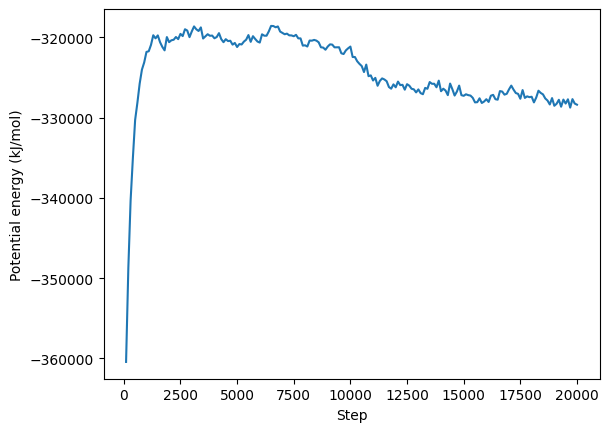

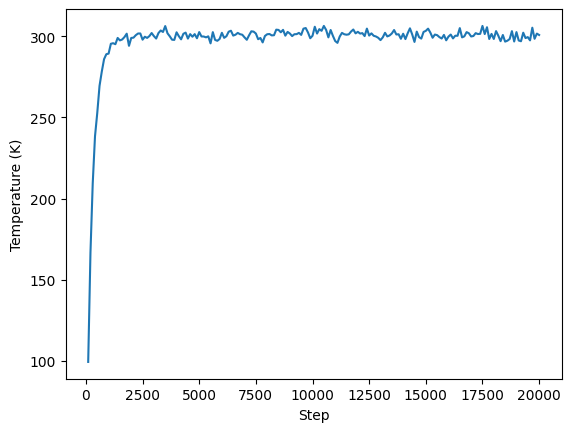

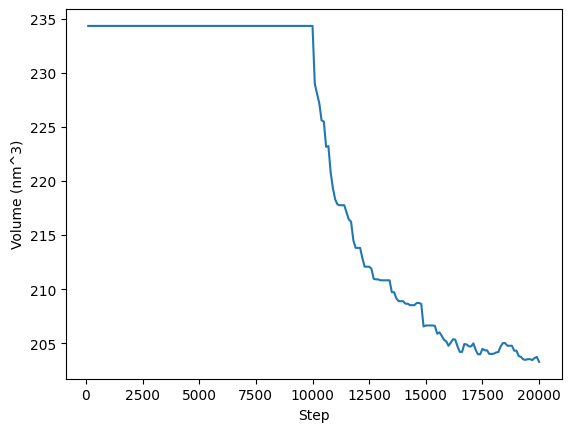

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data = np.loadtxt(output_pdb_md_log_file, delimiter=',')

step = data[:,0]
potential_energy = data[:,1]
temperature = data[:,2]
volume = data[:,3]

plt.plot(step, potential_energy)
plt.xlabel("Step")
plt.ylabel("Potential energy (kJ/mol)")
plt.show()
plt.plot(step, temperature)
plt.xlabel("Step")
plt.ylabel("Temperature (K)")
plt.show()
plt.plot(step, volume)
plt.xlabel("Step")
plt.ylabel("Volume (nm^3)")
plt.show()